## Cryogenic Materials Repository Tutorial
Author: Henry Nachman

Created: 22 July 2024 

Welcome to the Cryogenic Materials Repository - created by researchers at the University of Texas and supported by the CMB-S4 collaboration.

This notebook will walk you through the basics of using this repository using Python. By the end of this short tutorial you should be prepared to view the thermal conductivity fit of a material, and calculate and integrate the thermal conductivity using the fit.

First, let's start by resolving the necessary imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import pandas as pd

# Now we need to make sure that the parent folder is added to our path
# These paths may need to be adjusted on your machine

abspath = os.path.abspath("RepositoryTutorial.ipynb")
file_path = os.path.split(abspath)[0]
parent_dir = f"{file_path}{os.sep}..{os.sep}"
sys.path.insert(0, parent_dir)

from thermal_conductivity.tc_utils import *
from thermal_conductivity.tc_tools import *

Let's start by trying to load the fit compilation files.

In [2]:
# The following code is a 'smart' way of finding the most recently uploaded compilation file
all_files       = os.listdir(parent_dir)
exist_files     = [file for file in all_files if file.startswith("tc_fullrepo")]
tc_file_date    = exist_files[0][-12:-4]

TCdata = np.loadtxt(f"{path_to_tcFiles}{os.sep}tc_fullrepo_{tc_file_date}.csv", dtype=str, delimiter=',') # imports compilation file csv

Luckily, several functions have already been made to easily use the repository compilation files. For more information see the tc_tools.py file.

In [3]:
material_of_interest = "Stainless_Steel"
mat_parameters = get_parameters(TCdata, material_of_interest)
print(mat_parameters)

{'fit_type': 'comppoly', 'fit_range': array([4.500e-02, 1.672e+03]), 'low_param': [3.13158e-07, -6.66839e-05, 0.00384607, 0.058948], 'hi_param': [0.161695, -1.09799, 2.82413, -1.56968], 'erf_param': 119.471}


You'll notice that the return of 'get_parameters' is a dictionary of the fit parameters. Now, let's try and use that information to plot the fit for Stainless Steel.

<function loglog_func at 0x000001EC2850D5A0>


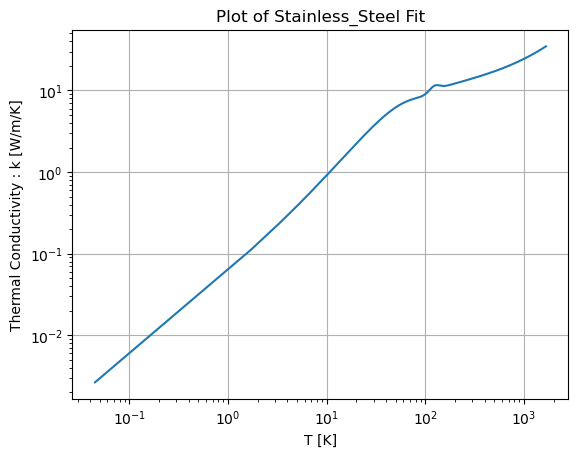

In [4]:
func_type = get_func_type(mat_parameters["fit_type"])
print(func_type)
fit_range = mat_parameters["fit_range"]

# Let's make our plotting range the listed fit range
T_range = np.linspace(fit_range[0], fit_range[1], 1000)

# Now let's use the fit to get the thermal conductivity values over the range
# Luckily, every function type is defined in such a way to readily accept the parameter dictionary as it was defined above
y_vals = func_type(T_range, mat_parameters)

# Plotting
plt.plot(T_range, y_vals)
plt.semilogy()
plt.semilogx()
plt.title(f"Plot of {material_of_interest} Fit")
plt.xlabel("T [K]")
plt.ylabel("Thermal Conductivity : k [W/m/K]")
plt.grid()
plt.show()

Great! Now that we know how to get the thermal conductivity at a given temperature value it is relatively straightforward to integrate over a specified range.

The provided function 'get_conductivity_integral' uses the built-in numpy.trapz function to calculate the integral.

In [5]:
T_low, T_high = [2, 20]
tc_integral = get_conductivity_integral(T_low, T_high, material_of_interest)

print(f"{tc_integral} W/m")

19.450966204859057 W/m


Just for fun, let's see what that region looks like on the plot

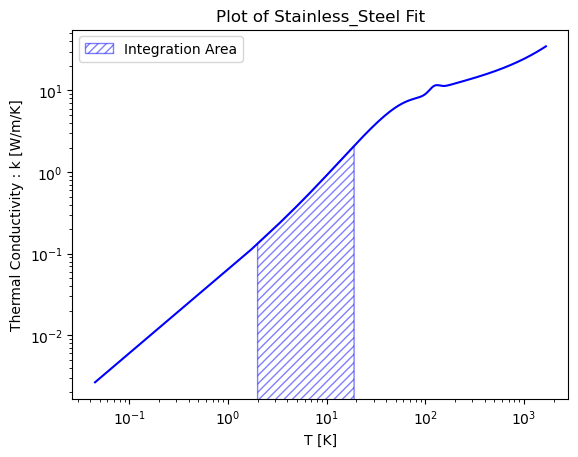

In [21]:
# Plotting
fill_between_range = np.arange(T_low, T_high)
plt.plot(T_range, y_vals, color="b")
plt.fill_between(fill_between_range, np.zeros(len(fill_between_range)), func_type(fill_between_range, mat_parameters),
                 hatch="////", alpha = 0.5, edgecolor = 'b', facecolor="w",
                 label="Integration Area")
plt.semilogy()
plt.semilogx()
plt.legend()
plt.title(f"Plot of {material_of_interest} Fit")
plt.xlabel("T [K]")
plt.ylabel("Thermal Conductivity : k [W/m/K]")
plt.show()